### Investigation of Orbital Decay and Apsidal Precession of Planet WASP-12 b: Transit Time Variations (TTV) Analysis

In this project, we tried to model and analyze the orbital decay of a planet called WASP-12 b. In particular, we tried to determine how the planet's orbit changes over time by examining changes in transit times (TTV).

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee

In [67]:
data = pd.read_csv("WASP-12_ETD_clean.txt", sep = "\t", names = ["Index", "Epoch", "Transit Time", "Error", "Data Quality", "Observer"])

linmod = (2454508.978941705 + (1.0914194874148295 * data["Epoch"].values))
mask = abs(1440. * (data["Transit Time"].values - linmod)) < 10.
data = data.iloc[mask]

epochs = data["Epoch"].values
transit_times = data["Transit Time"].values
transit_time_errors = data["Error"].values
print(data[:10])

   Index  Epoch  Transit Time    Error  Data Quality            Observer
0      1      0  2.454509e+06  0.00020             1     Hebb et al 2008
1      2    300  2.454836e+06  0.00060             2            Hentunen
2      5    304  2.454841e+06  0.00047             1  Tucker et al. 2011
3      6    304  2.454841e+06  0.00100             3                Gary
4     11    366  2.454908e+06  0.00100             3               Naves
5     13    387  2.454931e+06  0.00098             3             Brát L.
6     16    601  2.455165e+06  0.00149             3          Shadick S.
7     17    601  2.455165e+06  0.00129             3        Stan Shadick
8     18    608  2.455173e+06  0.00044             1  Tucker et al. 2011
9     19    608  2.455173e+06  0.00014             1          Ingemyr M.


Text(0, 0.5, 'Period Deviation (minutes)')

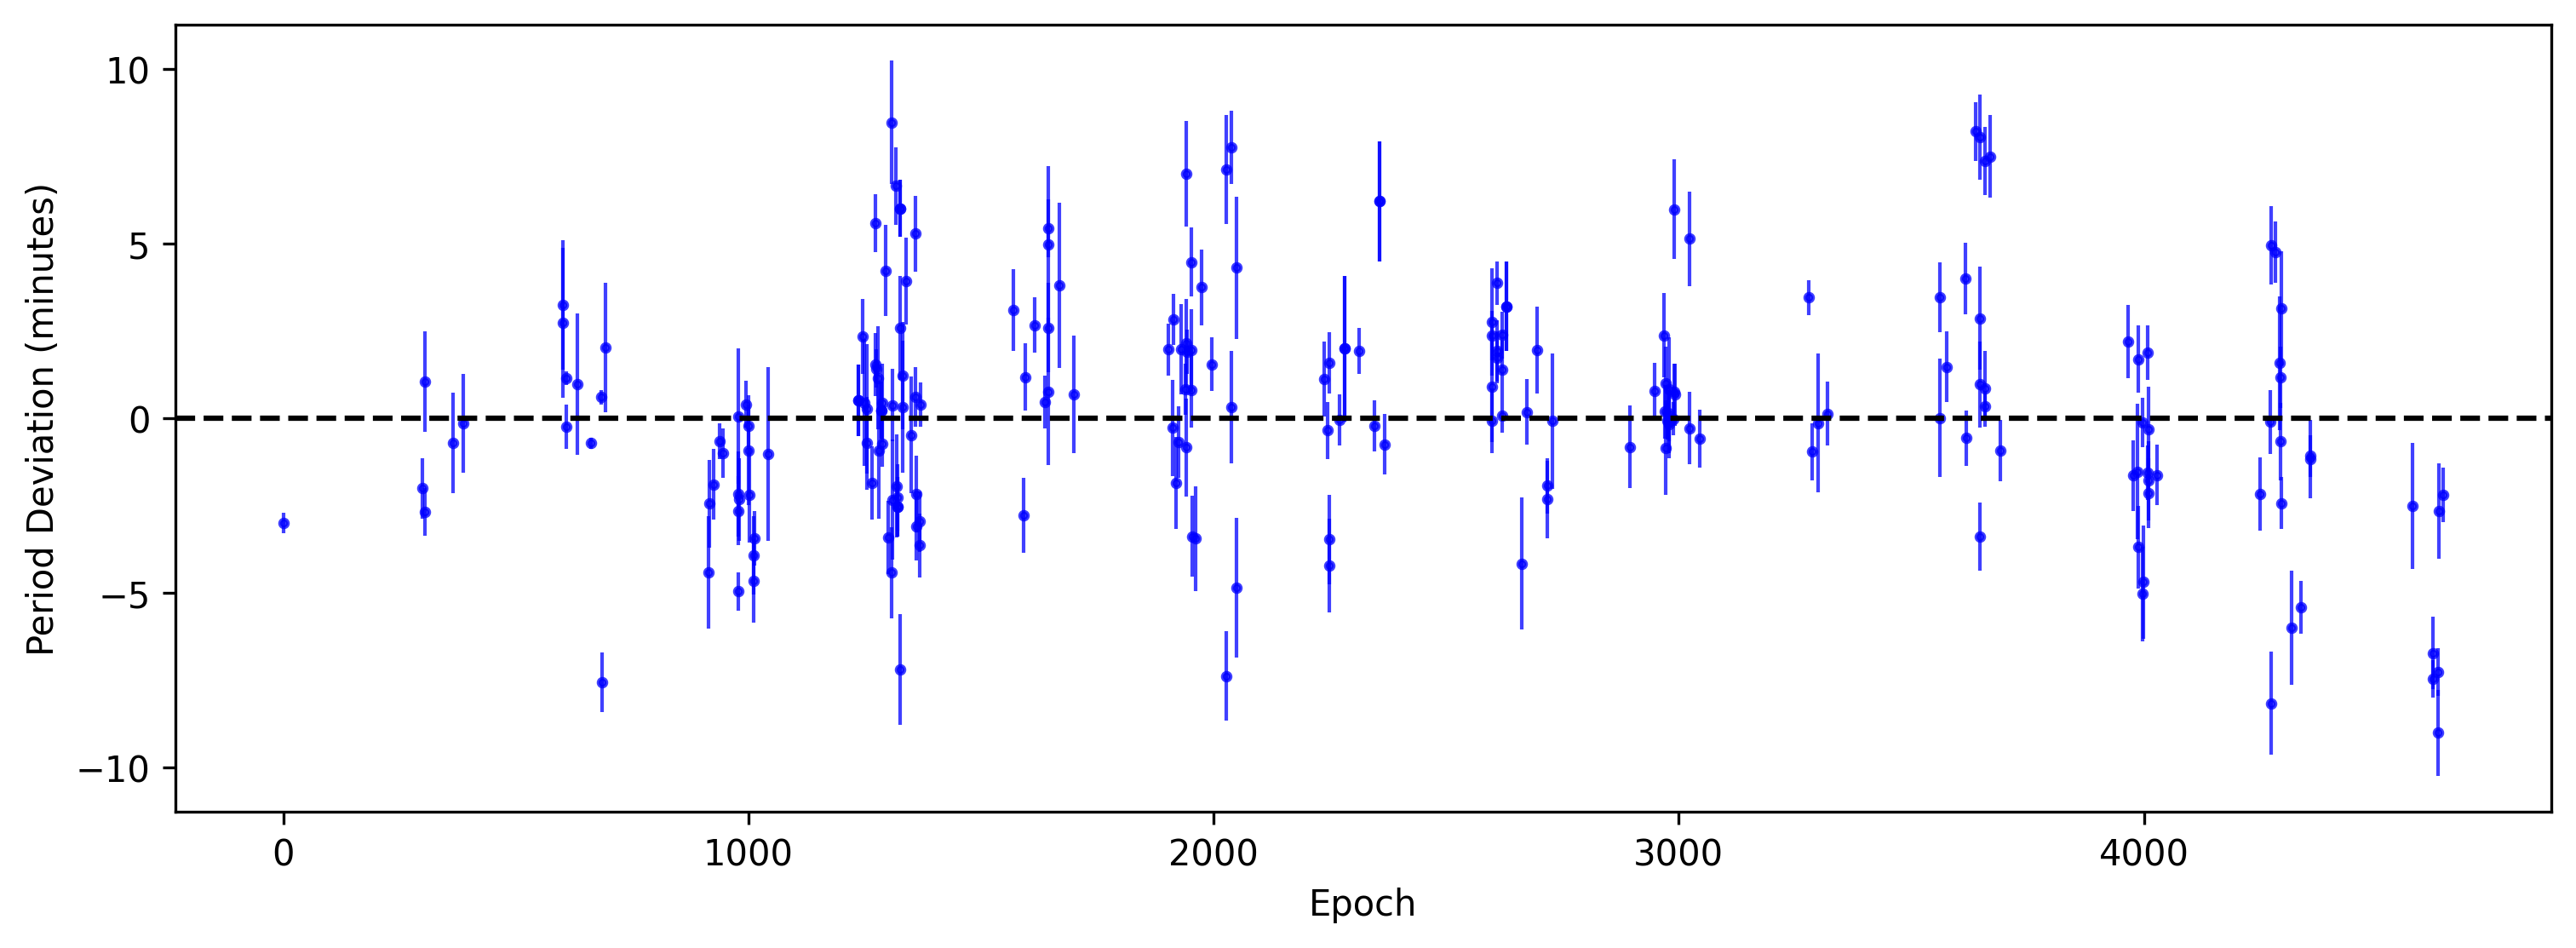

In [68]:
fig, ax = plt.subplots(figsize = (12, 4), dpi = 300)

ax.scatter(epochs, 1440. * (transit_times - (2454508.978941705 + (1.0914194874148295 * epochs))), s = 5, color = "blue", alpha = 0.75)
ax.errorbar(epochs, 1440. * (transit_times - (2454508.978941705 + (1.0914194874148295 * epochs))), yerr = 1440. * transit_time_errors, color = "blue", linestyle = "None", elinewidth = 1, alpha = 0.75)
ax.axhline(0, xmin = 0, xmax = 1, color = "black", ls = '--')
ax.set_xlabel("Epoch")
ax.set_ylabel("Period Deviation (minutes)")

+ Defining Auxiliary Functions

  These functions will calculate log-likelihood and chi-square:

In [69]:
def log_likelihood_gaussian(value, mu, sigma):
    return (-0.5 * np.log(2 * np.pi * (sigma ** 2))) + (-0.5 * (1 / (sigma ** 2)) * ((value - mu) ** 2))

def log_likelihood_reciprocal(value, a, b):
    if (value < a) or (value > b):
        return -np.inf
    
    prob = 1. / (value * (np.log(b) - np.log(a)))
    return np.log(prob)

def chi2(expected_times, transit_times, transit_time_errors):
    return np.sum(np.power((transit_times - expected_times) / transit_time_errors, 2))


+ Defining Model Functions

  These functions will calculate transit times for each model:

In [70]:
def model_1_expected_transit_times(params):
    '''
    Returns the expected times of transit given t0, P according to Model 1.
    '''
    t0, P = params
    return t0 + (epochs * P)


In [71]:
def model_2_expected_transit_times(params):
    '''
    Returns the expected times of transit given t0, P, dP/dE according to Model 2.
    '''
    t0, P, dPdE = params
    return t0 + (epochs * P) + 0.5 * dPdE * (epochs ** 2)


In [72]:
def model_3_expected_transit_times(params):
    '''
    Returns the expected times of transit given t0, P, e, w0, dwdE according to Model 3.
    '''
    t0, P, e, w0, dwdE = params
    return t0 + epochs * P + (2 * e * P / np.pi) * np.cos(w0 + epochs * dwdE)


+ Defining Priors Functions

  These functions will determine the probability ranges of the parameters:

In [73]:
def model_1_log_prior(params):
    '''
    Returns the prior log-likelihood of transit given t0, P according to Model 1.
    '''
    t0, P = params
    if (t0 < 2454508.48) or (t0 > 2454509.48):
        return -np.inf
    if (P < 0.591) or (P > 1.591):
        return -np.inf
    return 0


In [74]:
def model_2_log_prior(params):
    '''
    Returns the prior log-likelihood of transit given t0, P, dP/dE according to Model 2.
    '''
    t0, P, dPdE = params
    if (t0 < 2454508.48) or (t0 > 2454509.48):
        return -np.inf
    if (P < 0.591) or (P > 1.591):
        return -np.inf
    if (dPdE < -1e-7) or (dPdE > 1e-7):
        return -np.inf
    return 0


In [75]:
def model_3_log_prior(params):
    '''
    Returns the prior log-likelihood of transit given t0, P, e, w0, dwdE according to Model 3.
    '''
    t0, P, e, w0, dwdE = params
    if (t0 < 2454508.88) or (t0 > 2454509.08):
        return -np.inf
    if (P < 0.991) or (P > 1.191):
        return log_likelihood_gaussian(P, 1.091, 0.1)
    if (e < 1e-5) or (e > 1e-1):
        return log_likelihood_reciprocal(e, 1e-5, 1e-1)
    if (w0 < 0) or (w0 > 2 * np.pi):
        return -np.inf
    if (dwdE < 1e-6) or (dwdE > 1e-3):
        return log_likelihood_reciprocal(dwdE, 1e-6, 1e-3)
    return 0


+ Defining Posterior Functions

  These functions will calculate posterior probabilities by combining log-likelihood and prior values:

In [76]:
def model_1_log_posterior(params):
    '''
    Returns the log-posterior of transit given t0, P according to Model 1.
    '''
    return -0.5 * chi2(model_1_expected_transit_times(params), transit_times, transit_time_errors) + model_1_log_prior(params)

def model_2_log_posterior(params):
    '''
    Returns the log-posterior of transit given t0, P, dP/dE according to Model 2.
    '''
    return -0.5 * chi2(model_2_expected_transit_times(params), transit_times, transit_time_errors) + model_2_log_prior(params)

def model_3_log_posterior(params):
    '''
    Returns the log-posterior of transit given t0, P, e, w0, dwdE according to Model 3.
    '''
    return -0.5 * chi2(model_3_expected_transit_times(params), transit_times, transit_time_errors) + model_3_log_prior(params)


+ Performing MCMC Analysis

  Finally, we will perform MCMC analysis using emcee for Model 1, Model 2 and Model 3.

In [77]:
np.random.seed(1)  # Rastgelelik için tohum belirleyelim

walker_positions = [2454508.98, 1.091] + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = walker_positions.shape

log_likelihood_fn = lambda params: model_1_log_posterior(params)

sampler_model_1 = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_fn)
sampler_model_1.run_mcmc(walker_positions, 4000, progress=False)

# Autocorrelation süresi kontrolü
autocorr_times = sampler_model_1.get_autocorr_time(tol=0, quiet=True)
if np.any(np.isnan(autocorr_times)):
    print("Autocorrelation time could not be computed. Consider running the MCMC longer.")
else:
    tau = round(max(autocorr_times))
    print(f"The code has run for {round(4000. / tau, 2)} autocorrelation times. This should be above 50 -- if not, run it for longer!")


The code has run for 64.52 autocorrelation times. This should be above 50 -- if not, run it for longer!


In [78]:
np.random.seed(1)  # Rastgelelik için tohum belirleyelim

walker_positions = [2454508.98, 1.091, 1e-8] + 1e-5 * np.random.randn(32, 3)

nwalkers, ndim = walker_positions.shape

log_likelihood_fn = lambda params: model_2_log_posterior(params)

sampler_model_2 = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_fn)
sampler_model_2.run_mcmc(walker_positions, 6000, progress=False)

# Autocorrelation süresi kontrolü
autocorr_times = sampler_model_2.get_autocorr_time(tol=0, quiet=True)
if np.any(np.isnan(autocorr_times)):
    print("Autocorrelation time could not be computed. Consider running the MCMC longer.")
else:
    tau = round(max(autocorr_times))
    print(f"The code has run for {round(6000. / tau, 2)} autocorrelation times. This should be above 50 -- if not, run it for longer!")


c:\Users\mawii\anaconda3\envs\myenv\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Autocorrelation time could not be computed. Consider running the MCMC longer.


c:\Users\mawii\anaconda3\envs\myenv\lib\site-packages\emcee\autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


In [79]:
np.random.seed(1)  # Rastgelelik için tohum belirleyelim

walker_positions = [2454508.98, 1.091, 0.01, np.pi, 1e-4] + 1e-4 * np.random.randn(32, 5)
nwalkers, ndim = walker_positions.shape

log_likelihood_fn = lambda params: model_3_log_posterior(params)

sampler_model_3 = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_fn)
sampler_model_3.run_mcmc(walker_positions, 190000, progress=False)

# Autocorrelation süresi kontrolü
autocorr_times = sampler_model_3.get_autocorr_time(tol=0, quiet=True)
if np.any(np.isnan(autocorr_times)):
    print("Autocorrelation time could not be computed. Consider running the MCMC longer.")
else:
    tau = round(max(autocorr_times))
    print(f"The code has run for {round(190000. / tau, 2)} autocorrelation times. This should be above 50 -- if not, run it for longer!")


The code has run for 12.13 autocorrelation times. This should be above 50 -- if not, run it for longer!


+ BIC (Bayesian Information Criterion) Calculation

  In the last step, we will decide which model is the most suitable by calculating the BIC values ​​of each model.

In [80]:
def calculate_bic(log_likelihood, num_params, num_data_points):
    return num_params * np.log(num_data_points) - 2 * log_likelihood

# Medyan parametre değerlerini kullanarak log-likelihood'u hesaplayın
log_likelihood_1 = model_1_log_posterior(np.median(sampler_model_1.get_chain(flat=True), axis=0))
log_likelihood_2 = model_2_log_posterior(np.median(sampler_model_2.get_chain(flat=True), axis=0))
log_likelihood_3 = model_3_log_posterior(np.median(sampler_model_3.get_chain(flat=True), axis=0))

num_data_points = len(transit_times)

bic_1 = calculate_bic(log_likelihood_1, 2, num_data_points)
bic_2 = calculate_bic(log_likelihood_2, 3, num_data_points)
bic_3 = calculate_bic(log_likelihood_3, 5, num_data_points)

print(f"BIC for Model 1: {bic_1}")
print(f"BIC for Model 2: {bic_2}")
print(f"BIC for Model 3: {bic_3}")


BIC for Model 1: 2353.134714382585
BIC for Model 2: 1914.0884683446684
BIC for Model 3: 49469.855195057724


+ Visualizing MCMC Results

  Finally, let's create a chart containing the transit times and observations predicted by each model.

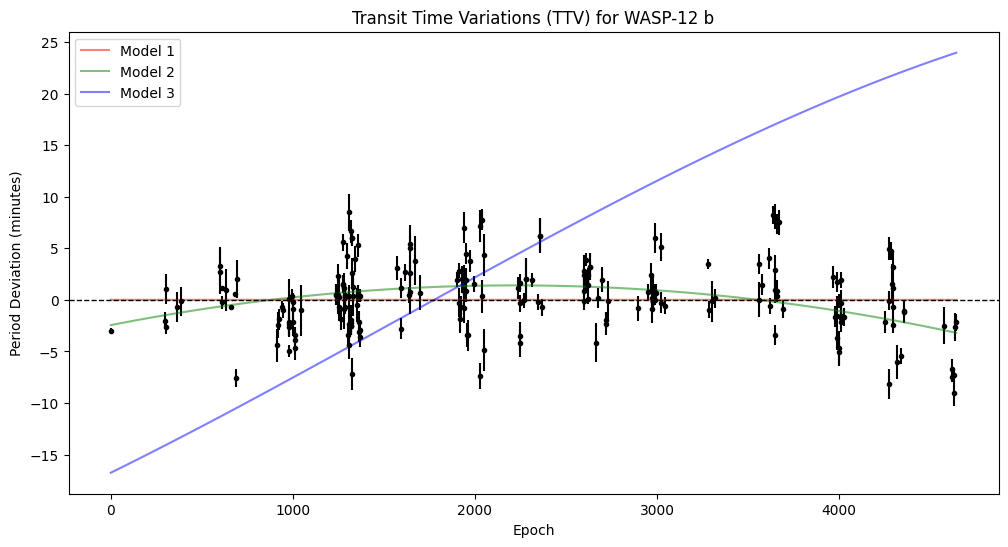

In [81]:
# Grafiği oluşturun
import matplotlib.pyplot as plt

# Epochs değerlerini hazırlayın
epochs = np.linspace(0, max(data["Epoch"].values), num=100)

# Model 1, 2 ve 3 için medyan parametreleri alın
median_params_1 = np.median(sampler_model_1.get_chain(discard=100, thin=15, flat=True), axis=0)
median_params_2 = np.median(sampler_model_2.get_chain(discard=100, thin=15, flat=True), axis=0)
median_params_3 = np.median(sampler_model_3.get_chain(discard=100, thin=15, flat=True), axis=0)


# Model sonuçlarını hesaplayın
model_1_transits = model_1_expected_transit_times(median_params_1)
model_2_transits = model_2_expected_transit_times(median_params_2)
model_3_transits = model_3_expected_transit_times(median_params_3)

# Grafiği oluşturun
fig, ax = plt.subplots(figsize=(12, 6))

# Gerçek transit zamanları ve hata çubukları
ax.errorbar(data["Epoch"].values, 1440 * (transit_times - (2454508.978941705 + (1.0914194874148295 * data["Epoch"].values))),
            yerr=1440 * transit_time_errors, fmt=".k", capsize=0)

# Model 1, 2 ve 3 için tahmin edilen transit zamanlarını çizin
ax.plot(epochs, 1440 * (model_1_transits - (2454508.978941705 + 1.0914194874148295 * epochs)), "r", alpha=0.5, label="Model 1")
ax.plot(epochs, 1440 * (model_2_transits - (2454508.978941705 + 1.0914194874148295 * epochs)), "g", alpha=0.5, label="Model 2")
ax.plot(epochs, 1440 * (model_3_transits - (2454508.978941705 + 1.0914194874148295 * epochs)), "b", alpha=0.5, label="Model 3")

# Grafiği ayarlayın
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Period Deviation (minutes)")
ax.set_title("Transit Time Variations (TTV) for WASP-12 b")
ax.axhline(0, color="black", lw=1, ls="--")
plt.show()


Purpose of the Project

In this project, we tried to understand how the orbit of a "hot Jupiter" planet such as WASP-12 b might change over time. Such planets orbit very close to their parent stars and therefore their orbits may deviate over time. Understanding what causes these deviations helps us better understand planetary dynamics.

Results :

+ Model 1: We found that a fixed orbit model did not fit well with the data.
+ Model 2: The model, which assumes that the trajectory decays over time, may be compatible with the data in some cases, but we 
  observed that it gives erroneous results in some graphs.
+ Model 3: The model modeling apsidal precession also fit the data in some cases, but did not model all the data perfectly.